In [1]:
using LinearAlgebra
using ProgressMeter
using Logging
using MLDatasets: FashionMNIST
using Random
using Plots
using ProfileView

include("../Models.jl")
include("../ActivationFunctions.jl")
include("../GraphCreation.jl")
include("../GraphPass.jl")
include("../InputOutput.jl")
include("../Layers.jl")
include("../LossFunctions.jl")
include("../Operations.jl")
include("../WeightInit.jl")
include("../NetworkOperations.jl")

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/micha/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/micha/snap/code/common/.cache/gio-modules/libgiolibproxy.so


netResult (generic function with 1 method)

In [2]:
function net(image::Variable, filters1::Variable, filters2::Variable, wages1::Variable, wages2::Variable, y::Variable, 
    bias1::Variable, bias2::Variable, bias3::Variable, bias4::Variable)
a_conv_res_input_preallocation = Constant(zeros(Float32, 28, 28, 1))
a_conv_res_filters_preallocation = Constant(zeros(Float32, 3, 3, 1, 6))
a = conv(image, filters1, a_conv_res_input_preallocation, a_conv_res_filters_preallocation)
a.name = "a Convolution"
a1 = bias(a, bias1)
a1.name = "a1 Bias"
a2_preallocated = Constant(zeros(Float32, 26, 26, 6))
a2 = relu(a1, a2_preallocated)
a2.name = "a2 ReLU"
b_max_pool_res_preallocation = Constant(zeros(Float32, 26, 26, 6))
b = maxPool(a2, Constant([2,2]), b_max_pool_res_preallocation)
b.name = "b MaxPool"

c_conv_res_input_preallocation = Constant(zeros(Float32, 13, 13, 6))
c_conv_res_filters_preallocation = Constant(zeros(Float32, 3, 3, 6, 16))
c = conv(b, filters2, c_conv_res_input_preallocation, c_conv_res_filters_preallocation)
c.name = "c Convolution"
c1 = bias(c, bias2)
c1.name = "c1 Bias"
c_relu_preallocated = Constant(zeros(Float32, 11, 11, 16))
c2 = relu(c1, c_relu_preallocated)
c2.name = "c2 ReLU"
d_max_pool_res_preallocation = Constant(zeros(Float32, 11, 11, 16))
d = maxPool(c2, Constant([2,2]), d_max_pool_res_preallocation)
d.name = "d MaxPool"

e = flatten(d)
e.name = "e Flatten"

f_preallocated_A = Constant(zeros(Float32, 400))
f_preallocated_x = Constant(zeros(Float32, 84, 400))
f = dense(wages1, e, bias3, f_preallocated_x, f_preallocated_A)
f.name = "f Dense"
f_relu_preallocated = Constant(zeros(Float32, 84))
f_relu = relu(f, f_relu_preallocated)

g_preallocated_A = Constant(zeros(Float32, 84))
g_preallocated_x = Constant(zeros(Float32, 10, 84))
g = dense(wages2, f_relu, bias4, softmax, g_preallocated_x, g_preallocated_A)
g.name = "g Dense"

loss = cross_entropy(y, g)
loss.name = "Loss"
return tuple(topological_sort(loss), topological_sort(g))
end

net (generic function with 1 method)

In [3]:
accuracyArray = Float64[]
losses = Float64[]

Float64[]

In [4]:
function main()
    image = Variable(Array{Float32, 3}(undef,28,28,1), name="Image")
    filters1 = Variable(glorot_uniform(3,3,1,6,Int32(3*3*1)), name="Filters1")
    filters2 = Variable(glorot_uniform(3,3,6,16,Int32(3*3*6)), name="Filters2")
    wages1 = Variable(glorot_uniform(84,400,Int32(84*400)), name="Wages1")
    wages2 = Variable(glorot_uniform(10,84,Int32(10*84)), name="Wages2")
    y = Variable(Vector{Float32}(undef,10), name="Expected result y")
    bias1 = Variable(glorot_uniform(26,26,6,Int32(26*26*6)), name="Bias 1")
    bias2 = Variable(glorot_uniform(11,11,16,Int32(11*11*16)), name="Bias 2")
    bias3 = Variable(glorot_uniform(84, Int32(84)), name="Bias 3")
    bias4 = Variable(glorot_uniform(10, Int32(10)), name="Bias 4")

    var_array = Variable[filters1, filters2, wages1, wages2, bias1, bias2, bias3, bias4]

    graph, test = net(image, filters1, filters2, wages1, wages2, y, bias1, bias2, bias3, bias4)

    trainDataset = FashionMNIST(:train)
    trainData = [tuple(reshape(trainDataset.features[:,:,i],28,28,1), trainDataset.targets[i]) for i in 1:60000]
    testDataset = FashionMNIST(:test)
    testData = [tuple(reshape(testDataset.features[:,:,i],28,28,1), testDataset.targets[i]) for i in 1:10000]

    # learning and testing parameters
    batchsize = 100
    testBatchSize = 10000

    numberOfBatchesInEpoch = trunc(Int32, length(trainDataset.targets)/batchsize)
    epochs = 15
    step = 0.01f0

    shuffle!(trainData)
    shuffle!(testData)

    #Initial test of network, before learning

    accuracy = testNetwork(testData, test, testBatchSize, image, y)
    push!(accuracyArray, accuracy)

    expectedOutput = Array{Float32}(undef,10)
    for j in 1:epochs
        # @time @showprogress for i in 1:numberOfBatchesInEpoch
        @time for i in 1:numberOfBatchesInEpoch
        # @showprogress for i in 1:epochs
        #     @info("
        # --------------------------------------------------------------
        # Starting epoch $i
        # --------------------------------------------------------------")
            currentloss = batch_process(graph,trainData[(i-1)*batchsize+1:i*batchsize], image, y, expectedOutput)
            push!(losses, currentloss)
            batch_update!(var_array, step, batchsize)

            reset!(graph)
        end
        accuracy = testNetwork(testData, test,testBatchSize, image, y)
        # println("Loss: ", currentloss)
        println("Accuracy: ", accuracy)
        push!(accuracyArray, accuracy)
        shuffle!(trainData)
    end
end

main (generic function with 1 method)

In [5]:
@time main()

 46.005701 seconds (39.25 M allocations: 1.958 GiB, 0.91% gc time, 25.55% compilation time)
Accuracy: 69.23
 33.798858 seconds (30.24 M allocations: 1.371 GiB, 0.46% gc time)
Accuracy: 75.16000000000001
 33.789264 seconds (30.24 M allocations: 1.371 GiB, 0.42% gc time)
Accuracy: 73.27
 34.596092 seconds (30.24 M allocations: 1.371 GiB, 0.42% gc time)
Accuracy: 77.98
 35.000657 seconds (30.24 M allocations: 1.371 GiB, 0.42% gc time)
Accuracy: 77.7
 33.803488 seconds (30.24 M allocations: 1.371 GiB, 0.43% gc time)
Accuracy: 80.43
 33.755122 seconds (30.24 M allocations: 1.371 GiB, 0.43% gc time)
Accuracy: 81.28
 33.827804 seconds (30.24 M allocations: 1.371 GiB, 0.43% gc time)
Accuracy: 81.74
 33.986326 seconds (30.24 M allocations: 1.371 GiB, 0.36% gc time)
Accuracy: 82.56
 34.216228 seconds (30.24 M allocations: 1.371 GiB, 0.35% gc time)
Accuracy: 82.73
 34.501251 seconds (30.24 M allocations: 1.371 GiB, 0.35% gc time)
Accuracy: 83.64
 34.414004 seconds (30.24 M allocations: 1.371 GiB,

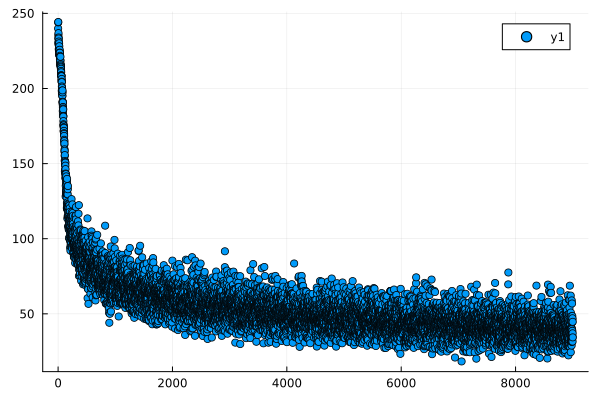

In [6]:
plot(1:length(losses), losses, seriestype=:scatter)

Accuracy array: [10.0, 69.23, 75.16000000000001, 73.27, 77.98, 77.7, 80.43, 81.28, 81.74, 82.56, 82.73, 83.64, 83.63000000000001, 83.67, 84.87, 84.63000000000001]


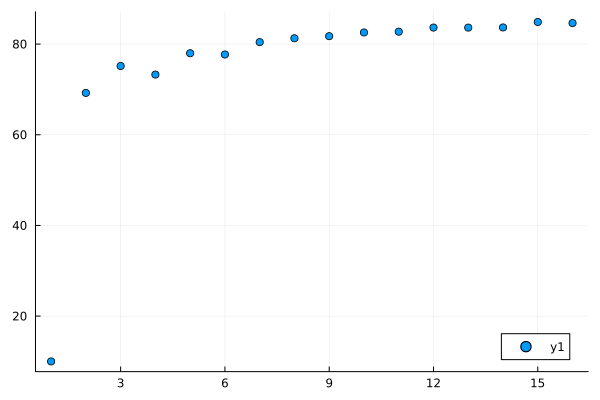

In [7]:
println("Accuracy array: ", accuracyArray)
plot(1:length(accuracyArray), accuracyArray, seriestype=:scatter)